# I. Introduction

In this project, the goal is to classify different physical activities (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data as accurately as possible. Different activities have been numbered with integers. We use the following encoding: 1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up. 

**Training Datasets**
1. train_time_series.csv
2. train_labels.csv

The first file, `train_time_series.csv`, contains the raw accelerometer data, which has been collected using the Beiwe research platform, and it has the following format: `timestamp, UTC time, accuracy, x, y, z`. The timestamp column is used as time variable; the last three columns, here labeled x, y, and z, correspond to measurements of linear acceleration along each of the three orthogonal axes. The second file `train_labels.csv` has the following format: `timestamp, UTC time, label`. Because the accelerometers are sampled at high frequency, the labels in `train_labels.csv` are only provided for every 10th observation in `train_time_series.csv`.

**Test Datasets**
1. test_time_series.csv
2. test_labels.csv

The file `test_time_series.csv` has the same format as the file `train_time_series.csv` and the data is unseen by the training and is for testing the prediction accuracy. An extra column `label` will be added based on the given `x, y, z` test data. 

### **Key Steps:**
1. Import all necessary modules and read in all datasets with `read_csv` method;
2. Add one column `label` to `train_time_series` with the corresponding labels from `train_labels` using timestamp as time variable;
3. Define covariates `x, y, z` and outcome `label` from `train_time_series`;
4. Instantiate all desired classifiers;
5. Fit the models and determine the cross-validated accuracy for logistic and random forest models and pick the more accurate model;
6. Add one predicted column `label` to `test_time_series`;
7. Replace the NaN in column `label` with corresponding labels from `test_time_series` in the `test_labels` dataframe.
8. Run a k-nearest neighbors classifier and repeat step 6 and 7 and test the classification accuracy in Submission and identify knn is the most accurate model.
9. Write `test_labels` to csv file.

# II. Methods: Logistic Regression, Random Forest Classifier, K-Nearest Neighbors Classifier

The process will be shown in the following cells. The data cleaning techniques include `dict( )`, `zip( )`, and `dropna( )` methods. Data exploration and visualization is implemented with `matplotlib.pyplot`. The output plot will show how each model performs in terms of classification accuracy. Finally we will adopt the model that presents higher accuracy scores.

# III. Results

In [1]:
#Step 1: Import all necessary modules and read in all datasets with read_csv method
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)

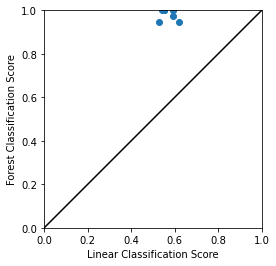

--- 2.3273708820343018 seconds ---


In [2]:
start_time = time.time()

train_label = pd.read_csv("train_labels.csv")
train_time_series = pd.read_csv("train_time_series.csv")
test_time_series = pd.read_csv("test_time_series.csv")
test_label = pd.read_csv("test_labels.csv")

#Step 2: Add one column label to train_time_series with the corresponding labels from train_labels using timestamp 
# as time variable;

dict_label = dict(zip(train_label['timestamp'], train_label['label']))
train_time_series["label"] = train_time_series.timestamp.map(dict_label)
# Drop the NaN rows in train_time_series dataframe
train_time_series.dropna(how="any", inplace =True)


#Step 3: Define covariates x, y, z and outcome label from train_time_series
classification_target = 'label'
classification_outcome = train_time_series[classification_target]
all_covariates = ["x", "y", "z"]
covariates = train_time_series[all_covariates]

#Step 4: Instantiate all desired classifiers
logistic_regression = LogisticRegression()
forest_classifier = RandomForestClassifier(max_depth=5, random_state=0)


#Step 5: Fit the models and determine the cross-validated accuracy for logistic and random forest models and pick 
# the more accurate model, which is Random Forest Classifier in this case

def accuracy(estimator, X, y):
    reg = estimator.fit(X, y)
    predictions = reg.predict(X)
    return accuracy_score(y, predictions)

logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv =10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv =10, scoring=accuracy)

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores)
plt.plot((0, 1), (0, 1), 'k-')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")

# Show the plot.
plt.show()


#Step 6: Add one predicted column label to test_time_series

forest_classifier.fit(covariates, classification_outcome)
test_time_series['label'] = forest_classifier.predict(test_time_series[all_covariates])
test_time_series['label'] = test_time_series['label'].astype('int64')


#Step 7: Replace the NaN in column label with corresponding labels from test_time_series in the test_labels dataframe

dict_test_label = dict(zip(test_time_series['timestamp'], test_time_series['label']))
test_label['label'] = test_time_series.timestamp.map(dict_test_label)


#Step 8: Run a k-nearest neighbors classifier and repeat step 6 and 7 and test the classification accuracy in Submission and identify knn is the most accurate model.

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(covariates, classification_outcome)
test_time_series['label'] = knn.predict(test_time_series[all_covariates])
test_time_series['label'] = test_time_series['label'].astype('int64')

dict_test_label = dict(zip(test_time_series['timestamp'], test_time_series['label']))
test_label['label'] = test_time_series.timestamp.map(dict_test_label)

#Step 9: Write test_labels to csv file.

test_label.to_csv("test_label_final.csv")

print("--- %s seconds ---" % (time.time() - start_time))


# IV. Conclusion

The project tests the prediction accuracty of three different classification models, namely logistic regression, random forest classifier and k-nearest neighbors classifier, on the data of tri-axial smartphone accelerometer. According to the plot shown, the random forest classifier performs better than the logistic classifier. Furthermore, by testing the k-nearest neighbors calssifier in the submission, we obtained 1% more accurate prediction. Therefore, the final submission uses the k-nearest neighbors classifier result.